In [ ]:
"""
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d jessicali9530/celeba-dataset
%%capture
!mkdir celeba
!unzip celeba-dataset.zip -d celeba
dataset = torchvision.datasets.CelebA(root = "/content/", split = "train", target_type = "bbox",)
"""

'\n! pip install -q kaggle\nfrom google.colab import files\nfiles.upload()\n! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets list\n! kaggle datasets download -d jessicali9530/celeba-dataset\n%%capture\n!mkdir celeba\n!unzip celeba-dataset.zip -d celeba\ndataset = torchvision.datasets.CelebA(root = "/content/", split = "train", target_type = "bbox",)\n'

In [ ]:
%%capture
!wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
!tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
!rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

In [ ]:
!pip install adabelief-pytorch==0.2.0
!pip install ranger-adabelief==0.1.0

!pip install pytorch-lightning
!pip install comet-ml

#==1.2.2
#==3.4.0

#!pip install torchtext==0.8.1

     |████████████████████████████████| 829kB 8.3MB/s 
     |████████████████████████████████| 276kB 25.7MB/s 
     |████████████████████████████████| 829kB 25.7MB/s 
     |████████████████████████████████| 112kB 19.9MB/s 
     |████████████████████████████████| 1.3MB 27.1MB/s 
     |████████████████████████████████| 143kB 57.2MB/s 
     |████████████████████████████████| 296kB 28.7MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=4dd6010833fe8cb4412bbc65587d4a7aa7c631523084cd5da2776c136dc9174d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=49c3a98c83895fb377be63f09ba8a00eaf214e61b9bfe798785acddb6647026f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    U

In [ ]:
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger

import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import PIL.Image

import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms #datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor

import pytorch_lightning as pl
from pytorch_lightning import seed_everything


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def seed_e(seed_value):
  seed_everything(seed_value)
  random.seed(seed_value)
  np.random.seed(seed_value) 
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        if random.random() < 0.5:
          color_jitter = transforms.ColorJitter(brightness=0.3, 
                                                contrast=0.3,
                                                saturation=0.3, 
                                                hue=0.1)
          image = color_jitter(image)
        return image, landmarks
    
    def random_blurint(self, image):
      if random.random() < 0.5:
        transform = transforms.GaussianBlur(3, sigma=(0.1, 2.0))
        image = transform(image)
      return image

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        #image = self.random_blurint(image)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        image = TF.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        #orig_im = cv2.imread(self.image_filenames[index],)
        image = cv2.imread(self.image_filenames[index],)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #orig_im = np.asarray(Image.open(self.image_filenames[index]))
        #image = np.asarray(Image.open(self.image_filenames[index]))
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

In [ ]:
class Dataset_Land(pl.LightningDataModule):
    def __init__(self, conf, *args, **kwargs): #*args, **kwargs hparams, steps_per_epoch
      super().__init__()
      self.hparams = conf
    
    def prepare_data(self):
      print("can add download here")
    
    def setup(self):
      dataset = FaceLandmarksDataset(Transforms())

      size_of_main = len(dataset)
      train_size = int(size_of_main*0.85)
      val_size = int((size_of_main - train_size)/2)
      test_size = size_of_main - train_size - val_size
      self.dataset_train, self.dataset_val, self.dataset_test  = torch.utils.data.random_split(dataset, 
                                              [train_size, val_size, test_size], 
                                              generator=torch.Generator().manual_seed(42))

    def train_dataloader(self):
      data_train = DataLoader(self.dataset_train, batch_size=self.hparams["batch_size"], num_workers=self.hparams["num_workers"], shuffle=True)
      return data_train

    def val_dataloader(self):
      val = DataLoader(self.dataset_val, batch_size=self.hparams["batch_size"], num_workers=self.hparams["num_workers"], shuffle=False)
      return val

    def test_dataloader(self):
      test = DataLoader(self.dataset_test, batch_size=self.hparams["batch_size"], num_workers=self.hparams["num_workers"], shuffle=False)
      return test


In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class Re_model(nn.Module):
    def __init__(self, re_dict):
      super(Re_model, self).__init__()
      self.feature_extractor = torchvision.models.mobilenet_v3_large() #out 960
      self.feature_extractor.classifier = nn.Identity()
      
      self.norm = nn.Conv1d(re_dict["feature_out"], re_dict["feature_out"], 1)
      
      self.w1 = nn.Linear(in_features = re_dict["feature_out"], out_features = int(re_dict["feature_out"] * 1.5))
      self.activation = Mish()
      self.dropout = nn.Dropout(re_dict["classificator_dropout"])
      self.w2 = nn.Linear(in_features = int(re_dict["feature_out"] * 1.5), out_features = re_dict["output_size"])
      
    def forward(self, x):
      x = self.feature_extractor(x)
      x = self.norm(x[:, :, None])[:, :, 0]
      
      x = self.activation(self.dropout(self.w1(x)))
      x = self.w2(x)

      return x

In [ ]:
model_params = {
    "feature_out": 960,
    "output_size": 68*2,
    "classificator_dropout": 0.1,
}

data_params = {
    "batch_size": 64,
    "num_workers": 4,
}

learning_params = {
    "optimizer": "belief", # "belief", "ranger_belief", "adam", adamW
    "lr": 3e-4, #
    "eplison_belief": 1e-16,
    "beta": [0.9, 0.999], # not used
    "weight_decouple": True, 
    "weight_decay": 1e-4,
    "rectify": True,
    #
    "add_sch": False,
    #
    "epochs": 20, #

    "swa": False,
    "swa_start_epoch": 25, #35
    "swa_lr": 5e-5,
}


re_dict = {
    "model": model_params,
    "data_params": data_params,
    "training": learning_params,
}

from adabelief_pytorch import AdaBelief
from ranger_adabelief import RangerAdaBelief

from torch.optim.swa_utils import AveragedModel, SWALR

In [ ]:
"""dataset = FaceLandmarksDataset(Transforms())
image, orig_im, landmarks = dataset[143]
print(orig_im.shape, image.shape)
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.transpose(0, 1).transpose(1,2).numpy().squeeze(),);
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);"""

'dataset = FaceLandmarksDataset(Transforms())\nimage, orig_im, landmarks = dataset[143]\nprint(orig_im.shape, image.shape)\nlandmarks = (landmarks + 0.5) * 224\nplt.figure(figsize=(10, 10))\nplt.imshow(image.transpose(0, 1).transpose(1,2).numpy().squeeze(),);\nplt.scatter(landmarks[:,0], landmarks[:,1], s=8);'

In [ ]:
model = Re_model(model_params)
img = torch.randn((1, 3, 224, 224))
out = model(img)
print(out.shape)

torch.Size([1, 136])


In [ ]:
class Re_pl(pl.LightningModule):
    def __init__(self, re_dict, *args, **kwargs): #*args, **kwargs hparams, steps_per_epoch
        super().__init__()
        self.save_hyperparameters(re_dict)
        self.save_hyperparameters()
        #self.hparams = hparams
        self.swa_model = None

        self.network = Re_model(self.hparams["model"])
        self.learning_params = self.hparams["training"]

        self.swa_mode = False

        self.criterion = nn.MSELoss()

    def forward(self, x):
        if not self.swa_mode:
            return self.network(x)#.float())
        else:
            return self.swa_model(x)#.float())
    

    def configure_optimizers(self):
        if self.learning_params["optimizer"] == "belief":
            optimizer =  AdaBelief(self.parameters(), lr = self.learning_params["lr"], eps = self.learning_params["eplison_belief"],
                                    weight_decouple = self.learning_params["weight_decouple"], 
                                    weight_decay = self.learning_params["weight_decay"], rectify = self.learning_params["rectify"])
        elif self.learning_params["optimizer"] == "ranger_belief":
            optimizer = RangerAdaBelief(self.parameters(), lr = self.learning_params["lr"], eps = self.learning_params["eplison_belief"],
                                       weight_decouple = self.learning_params["weight_decouple"],  weight_decay = self.learning_params["weight_decay"],)
        elif self.learning_params["optimizer"] == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_params["lr"])
        elif self.learning_params["optimizer"] == "adamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_params["lr"])        

        if self.learning_params["add_sch"]:
            lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer,
	                                                                        max_lr=self.learning_params["lr"],
	                                                                        steps_per_epoch=self.hparams.steps_per_epoch, #int(len(train_loader))
	                                                                        epochs=self.learning_params["epochs"],
	                                                                        anneal_strategy='linear'),
                        'name': 'lr_scheduler_lr',
                        'interval': 'step', # or 'epoch'
                        'frequency': 1,
                        }
            print("sch added")
            return [optimizer], [lr_scheduler]

        return optimizer
    

    def training_step(self, batch, batch_idx):
        #also Manual optimization exist
        images, landmarks = batch
        landmarks = landmarks.view(landmarks.size(0),-1)
        
        predictions = self(images)

        loss = self.criterion(predictions, landmarks)

        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True) # prog_bar=True
        return loss

    #copied
    def get_lr_inside(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']


    def training_epoch_end(self, outputs):
        self.log('epoch_now', self.current_epoch, on_step=False, on_epoch=True, logger=True)
        (oppp) =  self.optimizers(use_pl_optimizer=True)
        self.log('lr_now', self.get_lr_inside(oppp), on_step=False, on_epoch=True, logger=True)
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/3095
        if self.learning_params["swa"] and (self.current_epoch >= self.learning_params["swa_start_epoch"]):
            if self.swa_model is None:
                (optimizer) =  self.optimizers(use_pl_optimizer=True)
                print("creating_swa")
                self.swa_model = AveragedModel(self.network)
                self.new_scheduler = SWALR(optimizer, anneal_strategy="linear", anneal_epochs=5, swa_lr = self.learning_params["swa_lr"])
            # https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
            self.swa_model.update_parameters(self.network)
            self.new_scheduler.step()
    

    def change_for_swa(self, loader):
        print("will it work?")
        torch.optim.swa_utils.update_bn(loader, self.swa_model)
        self.swa_mode = True
        return


    def validation_step(self, batch, batch_idx):

        images, landmarks = batch
        landmarks = landmarks.view(landmarks.size(0),-1)
        
        predictions = self(images)

        loss = self.criterion(predictions, landmarks)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True) # prog_bar=True

        return {'val_loss': loss}


    def test_step(self, batch, batch_idx):
        images, landmarks = batch
        landmarks = landmarks.view(landmarks.size(0),-1)
        
        predictions = self(images)

        loss = self.criterion(predictions, landmarks)

        self.log('test_loss', loss, on_step=False, on_epoch=True, logger=True) #prog_bar=True,

        return {'test_loss': loss}


In [ ]:
seed_v = 42
root_dir = "drive/My Drive/eye_w"
naming = "first_try"
from datetime import datetime

seed_e(seed_v)
comet_logger = CometLogger(
  save_dir='/content/log/',
  api_key="23CU99n7TeyZdPeegNDlQ5aHf",
  project_name="eye",
  workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)
#
dataset_pl = Dataset_Land(re_dict["data_params"])
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))
print(steps_per_epoch)

proj_a = Re_pl(re_dict, steps_per_epoch = steps_per_epoch)
trainer = Trainer(#callbacks=[lr_monitor],
                  logger=comet_logger,
                  gpus=1,
                  profiler=True,
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = re_dict["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)
#~
trainer.fit(proj_a, dataset_pl)
trainer.test()
if re_dict["training"]["swa"]:
  proj_a.change_for_swa(dataset_pl.train_dataloader())
  trainer.test() # will it work?
#.
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)


Global seed set to 42
CometLogger will be initialized in online mode


can add download here


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etzelkut/eye/8a2f58c53d05447dac449dd90743a2f7
COMET INFO:   Others:
COMET INFO:     Name : first_try
COMET INFO:   Parameters:
COMET INFO:     data_params/batch_size              : 64
COMET INFO:     data_params/num_workers      

89
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


COMET INFO:     re_dict/training/rectify            : True
COMET INFO:     re_dict/training/swa                : 1
COMET INFO:     re_dict/training/swa_lr             : 5e-05
COMET INFO:     re_dict/training/swa_start_epoch    : 25
COMET INFO:     re_dict/training/weight_decay       : 0.0001
COMET INFO:     re_dict/training/weight_decouple    : True
COMET INFO:     steps_per_epoch                     : 89
COMET INFO:     training/add_sch                    : 1
COMET INFO:     training/beta                       : [0.9, 0.999]
COMET INFO:     training/eplison_belief             : 1e-16
COMET INFO:     training/epochs                     : 20
COMET INFO:     training/lr                         : 0.0003
COMET INFO:     training/optimizer                  : belief
COMET INFO:     training/rectify                    : True
COMET INFO:     training/swa                        : 1
COMET INFO:     training/swa_lr                     : 5e-05
COMET INFO:     training/swa_start_epoch            : 

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0014488514279946685}
--------------------------------------------------------------------------------


In [ ]:
"""PATH = "/content/drive/MyDrive/eye_w/first_try.ckpt"
proj_check2 = Re_pl.load_from_checkpoint(PATH)
proj_check2.eval()
proj_check2.freeze()

from irislandmarks import IrisLandmarks

net = IrisLandmarks().to(device)
net.load_weights("irislandmarks.pth")"""

In [ ]:
from irislandmarks import IrisLandmarks

class Connect_module():
  def __init__(self, path_cascade, path_dots, path_eye_model):
    self.face_cascade = cv2.CascadeClassifier(path_cascade)
    self.transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
                                        )
    self.dots_model = Re_pl.load_from_checkpoint(path_dots).to(device)
    self.dots_model.eval()
    self.dots_model.freeze()
    self.eye_model = IrisLandmarks().to(device)
    self.eye_model.load_weights("irislandmarks.pth")
  
  def forward_dots(self, image):
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = self.face_cascade.detectMultiScale(image1, 1.1, 4)
    if len(faces) != 0:
      (x, y, w, h) = faces[0]
    else:
      (x, y, w, h) = (0, 0, 400, 400)
    
    if y+h >= image1.shape[0]:
      max_y = image1.shape[0] - 1
    else:
      max_y = y+h
    
    if x+w >= image1.shape[1]:
      max_x = image1.shape[1] - 1
    else:
      max_x = x+w
    
    new_img = image1[y:max_y, x:max_x]
    new_img = PIL.Image.fromarray(new_img)
    new_img = self.transforms(new_img).to(device)
    landmarks = self.dots_model(new_img.unsqueeze(0))
    landmarks = (landmarks.view(68,2).cpu().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
    eyes_pos = np.copy(landmarks[36:48])

    left = eyes_pos[0:6]
    right = eyes_pos[6:12]
    eyes_pos, left, right
    l_mean = np.mean(left, axis=0)
    r_mean = np.mean(right, axis=0)

    return image1, np.round(landmarks).astype(int), l_mean, r_mean, left, right

  def forward_eye(self, image, l_mean, r_mean):
    poslr = np.zeros((2, 2))
    poslr[0] = l_mean
    poslr[1] = r_mean

    poslr = np.round(poslr - [50, 50]).astype(int)
    lll = poslr[0]
    rrr = poslr[1]
    left_eye_im = image[lll[1]-30:lll[1]+120, lll[0]:lll[0]+100]
    right_eye_im = image[rrr[1]-30:rrr[1]+120, rrr[0]:rrr[0]+100]

    img = np.zeros((2, 64, 64, 3))

    #img[0] = cv2.resize(left_eye_im, (64, 64))
    #img[1] = cv2.resize(right_eye_im, (64, 64))

    try:
      img[0] = cv2.resize(left_eye_im, (64, 64))
      img[1] = cv2.resize(right_eye_im, (64, 64))

    except Exception as e:
      print(str(e))

    _, iris_gpu = self.eye_model.predict_on_batch(img)
    iris = iris_gpu.cpu().numpy()

    return iris, lll, rrr

  def forward(self, image1):
    image, landmarks, l_mean, r_mean, left, right = self.forward_dots(image1)

    def get_new(left):
      new_left = np.zeros((4, 2))
      new_left[0], new_left[1], new_left[2], new_left[3] = left[0], np.mean(left[1:3], axis = 0), left[3], np.mean(left[4:6], axis = 0)
      return new_left

    new_left = get_new(left)
    new_right = get_new(right)

    iris, lll, rrr = self.forward_eye(image, l_mean, r_mean)

    w, h = 100/64, 150/64

    for (y, x) in landmarks:
      image[x-2:x+2, y-2:y+2] = [255, 0, 0]
    
    x, y = iris[0][:, 0], iris[0][:, 1]
    x = x * w  + lll[0] - 1
    y = y * h  + lll[1] - 31

    for i in range(5):
      x1 = np.round(x[i]).astype(int)
      y1 = np.round(y[i]).astype(int)
      image[y1-2:y1+2, x1-2:x1+2] = [0, 255, 0]

    def get_newxy(x, y, new_left):
      to_left = x - new_left[0][0]
      to_right = x - new_left[2][0]
      to_top = y - new_left[1][1]
      to_bottom = y - new_left[3][1]

      new_x = (to_right + to_left) * 2
      new_y = (to_top + to_bottom)

      att_x = int(x + new_x) #!
      att_y = int(y + new_y) #!

      return att_x, att_y
    
    att_x, att_y = get_newxy(x[0], y[0], new_left) #!
    dis1, dis2 = y[4] - y[2], new_left[0][0] - new_left[2][0] #!
    dis2 = int(dis2) #!

    blank = np.zeros((100, 100, 3))
    red = (dis2**2)/125 * 255
    blue = (128 - dis2) if dis2 < 128 else 0
    blank[:, :, 0:3] = [red, 0, 0]
    image[0:100, 0:100] = blank

    x, y = iris[1][:, 0], iris[1][:, 1]
    x = x * w  + rrr[0] - 1
    y = y * h  + rrr[1] - 31
    
    for i in range(5):
      x1 = np.round(x[i]).astype(int)
      y1 = np.round(y[i]).astype(int)
      image[y1-2:y1+2, x1-2:x1+2] = [0, 255, 0]
    
    image[att_y-10:att_y+10, att_x-10:att_x+10] = [0, 0, 255]
    #att_x, att_y = get_newxy(x[0], y[0], new_right) #!
    #image[att_y-5:att_y+5, att_x-5:att_x+5] = [0, 0, 255]
    return image

In [ ]:
path_cascade = 'haarcascade_frontalface_default.xml'
path_dots = "/content/drive/MyDrive/eye_w/first_try.ckpt"
path_eye_model = "irislandmarks.pth"

projj = Connect_module(path_cascade, path_dots, path_eye_model)

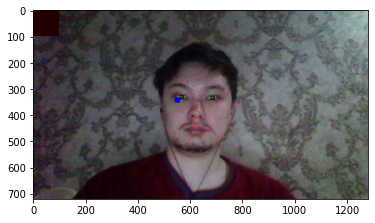

In [ ]:
image_path =  "/content/photocheckclose2.jpeg" #'/content/Photo-1-close.jpeg'
image1 = cv2.imread(image_path)
image = projj.forward(image1)
im = PIL.Image.fromarray(image)
im.save("out1.jpeg")
plt.imshow(image)

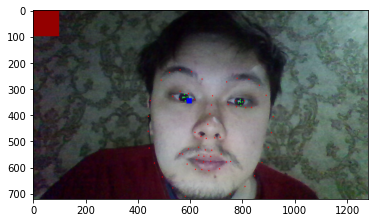

In [ ]:
image_path =  '/content/Photo-1-close.jpeg' #'/content/Photo-1-close.jpeg'
image1 = cv2.imread(image_path)
image = projj.forward(image1)
im = PIL.Image.fromarray(image)
im.save("out2.jpeg")
plt.imshow(image)

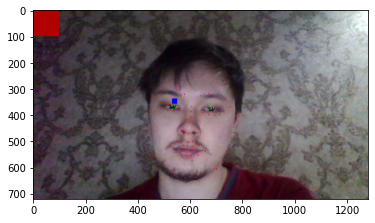

In [ ]:
image_path = '/content/Photo-1.jpeg' 
image1 = cv2.imread(image_path)
image = projj.forward(image1)
im = PIL.Image.fromarray(image)
im.save("out3.jpeg")
plt.imshow(image)

In [ ]:
source = "/content/screen-capture5.webm"
video = cv2.VideoCapture(source)

# We need to check if camera 
# is opened previously or not 
if (video.isOpened() == False):  
    print("Error reading video file") 
  
# We need to set resolutions. 
# so, convert them from float to integer. 
frame_width = int(video.get(3)) 
frame_height = int(video.get(4)) 
   
size = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
result = cv2.VideoWriter('filename2.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size) 

sizee = True

while(True): 
    ret, frame = video.read() 
  
    if ret == True:  
  
        # Write the frame into the 
        # file 'filename.avi' 
        frame1 = projj.forward(frame)
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR)
        result.write(frame1) 
  
        # Display the frame 
        # saved in the file 
  
        # Press S on keyboard  
        # to stop the process 
        if cv2.waitKey(1) & 0xFF == ord('s'): 
            break
  
    # Break the loop 
    else: 
        break
  
# When everything done, release  
# the video capture and video  
# write objects 
video.release() 
result.release()
# Closes all the frames 
cv2.destroyAllWindows() 

print("The video was successfully saved") 

The video was successfully saved


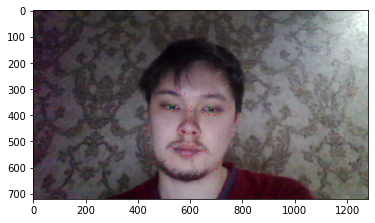

In [ ]:
image = projj.forward(image)
plt.imshow(image)

In [ ]:
os.listdir()

['.config',
 'photo.jpg',
 'log',
 'irislandmarks.pth',
 'screen-capture.webm',
 '__pycache__',
 'drive',
 'haarcascade_frontalface_default.xml',
 'Photo-1.jpeg',
 'Photo-2.jpeg',
 'ibug_300W_large_face_landmark_dataset',
 '.ipynb_checkpoints',
 'foo.jpeg',
 'your_file.jpeg',
 'irislandmarks.py',
 'sample_data']

In [ ]:
from IPython.display import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 1280, 720);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '1200px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 1280; //video.videoWidth;
      captureCanvas.height = 720; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([720,1280,3], dtype=np.uint8) #  720, 1280
    bbox_array = projj.forward(img)

    """    
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    """

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

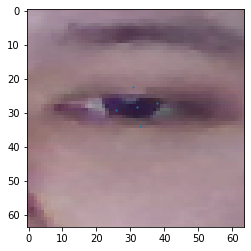

In [ ]:
plt.imshow(img, zorder=1)
x, y = iris[:, :, 0], iris[:, :, 1]
plt.scatter(x, y, zorder=2, s=1.0)
plt.show()

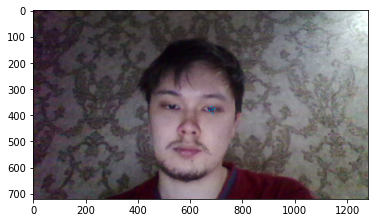

In [ ]:
plt.imshow(display_image, zorder=1)
x, y = iris[:, :, 0], iris[:, :, 1]
x = x * (100/64) + rrr[0]
y = y * (150/64) + rrr[1] - 30
plt.scatter(x, y, zorder=2, s=1.0)
#plt.savefig('foo.jpeg')
plt.show()

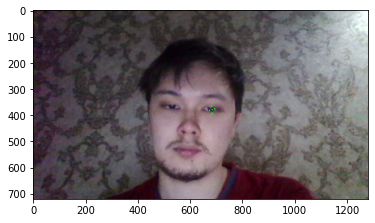

In [ ]:
im = Image.fromarray(new_img)
im.save("your_file.jpeg")
plt.imshow(new_img)